# Ridge and LASSO regression

Both methods use a penalization function in the estimation of the cost: $$min~||y-f(x|\theta)||^{2}-\lambda(\theta)$$.

### Example: fitting the distance modulus of Super-Novae (SNs) as a function of redshift

Let's suppose to have data for the distance modulus $\mu$ of SNs as a function of $z$. This is a complicated function which we will pretend to ignore. We will instead try to expand the function $\mu(z)$ (the predictive function we aim to derive) over a base of 100 Gaussians.

For simplicity, we will assume the Gaussians all have the same $\sigma$ = 2. The centers of the Gaussians are also fixed (one centered every $\Delta z \sim$ 0.025). What is left to be fit are then just the normalizations of the Gaussians. These normalizations will constitute the values of the set **θ** for this example. For each Gaussian centered at a given $z$ we will then have one $θ_p$($z$).

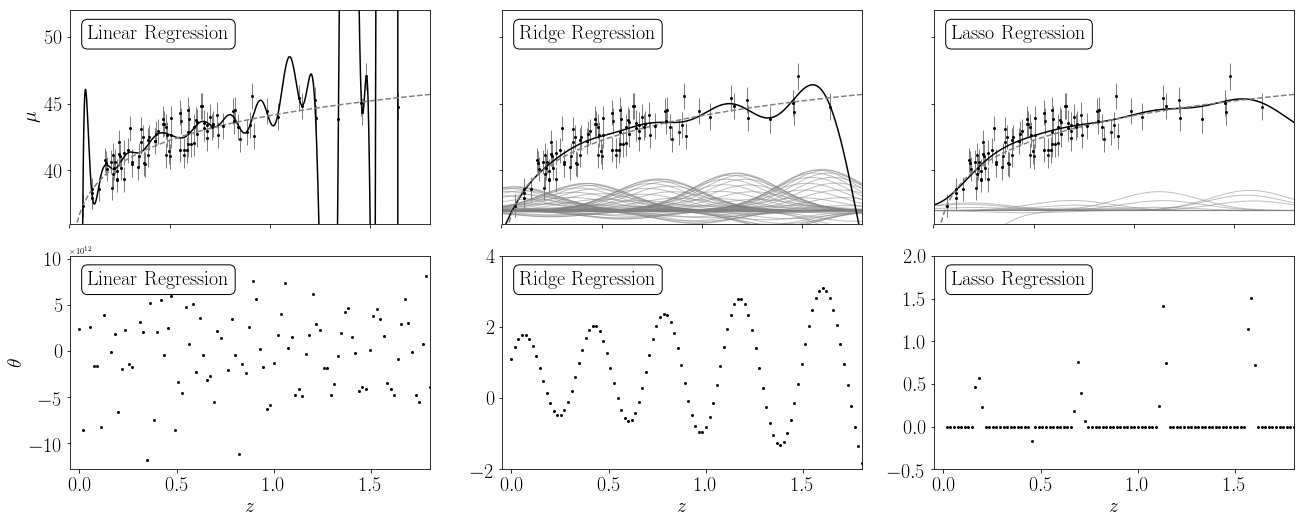

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

# Importing Libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = (map(cosmo.mu, z))
# NOTE: removed "asarray"

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(20, 7.5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))
    
    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)
       
    mu = list(mu)
    # NOTE: converting map to list or else plotting won't work
    
    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')

    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)
    
plt.show()